# rule based feature 추출

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter

%matplotlib inline

## Cathode

In [2]:
Cathode_Normal = sorted([x for x in Path("../data/230507/Cathode/Normal").glob("*.csv")])
Cathode_Normal

[PosixPath('../data/230507/Cathode/Normal/20230330_134146_0__02_Total.csv'),
 PosixPath('../data/230507/Cathode/Normal/48.csv'),
 PosixPath('../data/230507/Cathode/Normal/49.csv'),
 PosixPath('../data/230507/Cathode/Normal/50.csv'),
 PosixPath('../data/230507/Cathode/Normal/51.csv'),
 PosixPath('../data/230507/Cathode/Normal/52.csv'),
 PosixPath('../data/230507/Cathode/Normal/53.csv'),
 PosixPath('../data/230507/Cathode/Normal/54.csv'),
 PosixPath('../data/230507/Cathode/Normal/55.csv'),
 PosixPath('../data/230507/Cathode/Normal/56.csv'),
 PosixPath('../data/230507/Cathode/Normal/58.csv'),
 PosixPath('../data/230507/Cathode/Normal/59.csv'),
 PosixPath('../data/230507/Cathode/Normal/61.csv'),
 PosixPath('../data/230507/Cathode/Normal/62.csv'),
 PosixPath('../data/230507/Cathode/Normal/63.csv'),
 PosixPath('../data/230507/Cathode/Normal/64.csv'),
 PosixPath('../data/230507/Cathode/Normal/65.csv'),
 PosixPath('../data/230507/Cathode/Normal/67.csv'),
 PosixPath('../data/230507/Cathode/Norm

In [3]:
len(Cathode_Normal)

31

In [4]:
Cathode_Abnormal = sorted([x for x in Path("../data/230507/Cathode/Abnormal").glob("*.csv")])
Cathode_Abnormal

[PosixPath('../data/230507/Cathode/Abnormal/20230330_134728_0__03_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_134935_0__04_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_135219_0__05_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_135426_0__06_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_140214_0__07_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_140723_0__08_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_140937_0__09_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_141439_0__11_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_141754_0__12_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_142019_0__13_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_142247_0__14_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330_142807_0__16_Total.csv'),
 PosixPath('../data/230507/Cathode/Abnormal/20230330

In [5]:
len(Cathode_Abnormal)

17

In [6]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [7]:
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

### Dataset별 bead detection 후 time series concat

In [8]:
def slice_bead_data(path):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'
    
    total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
    
    for i in range(1, len(bead_array)):
        bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
        bead_data['bead_num'] = str(i)
        if 'Abnormal' in path:
            bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
        
        else:
            bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
            
        total_data = pd.concat([total_data, bead_data])
                
    
    return total_data

## Train Test split
### Train -> 31개 정상 dataset 중 80%인 25개
### Test -> 17개 비정상 dataset + 정상 6개 dataset = 23개 dataset

In [9]:
data_folder_list = Cathode_Normal + Cathode_Abnormal
num_train_dataset = 25
Cathode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
Cathode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]))
    Cathode_Train = pd.concat([Cathode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]))
    Cathode_Test = pd.concat([Cathode_Test, bead_i])

warning index: 59479
error index: 59578
warning index: 60128
error index: 60227
warning index: 60777
error index: 60876
warning index: 61427
error index: 61526
warning index: 62076
error index: 62175
warning index: 62725
error index: 62824
warning index: 63374
error index: 63473
warning index: 64022
error index: 64121
warning index: 64671
error index: 64770
warning index: 65321
error index: 65420
warning index: 65970
error index: 66069
warning index: 66619
error index: 66718
warning index: 67268
error index: 67367
warning index: 67917
error index: 68016
warning index: 68567
error index: 68666
warning index: 69216
error index: 69315
warning index: 69865
error index: 69964
warning index: 70514
error index: 70613
warning index: 71163
error index: 71262
warning index: 71813
error index: 71912
warning index: 72462
error index: 72561
warning index: 73111
error index: 73210
warning index: 73760
error index: 73859
warning index: 74409
error index: 74508
warning index: 75058
error index: 75157


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

warning index: 37684
error index: 37783
warning index: 38334
error index: 38433
warning index: 38983
error index: 39082
warning index: 39632
error index: 39731
warning index: 40281
error index: 40380
warning index: 40930
error index: 41029
warning index: 41580
error index: 41679
warning index: 42230
error index: 42329
warning index: 42879
error index: 42978
warning index: 43529
error index: 43628
warning index: 44178
error index: 44277
warning index: 44828
error index: 44927
warning index: 45477
error index: 45576
warning index: 46126
error index: 46225
warning index: 46776
error index: 46875
warning index: 47425
error index: 47524
warning index: 48074
error index: 48173
warning index: 48723
error index: 48822
warning index: 49372
error index: 49471
warning index: 50021
error index: 50120
warning index: 50671
error index: 50770
warning index: 51320
error index: 51419
warning index: 51970
error index: 52069
warning index: 52619
error index: 52718
warning index: 53269
error index: 53368


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


warning index: 45440
warning index: 45441
error index: 45540
warning index: 46090
warning index: 46091
error index: 46190
warning index: 46739
warning index: 46740
error index: 46838
warning index: 47388
error index: 47487
warning index: 48037
error index: 48136
warning index: 48686
error index: 48785
warning index: 49336
error index: 49435
warning index: 49986
error index: 50085
warning index: 50635
error index: 50734
warning index: 51285
error index: 51384
warning index: 51934
error index: 52033
warning index: 52584
error index: 52683
warning index: 53233
error index: 53332
warning index: 53882
error index: 53981
warning index: 54532
error index: 54631
warning index: 55181
error index: 55280
warning index: 55830
error index: 55929
warning index: 56479
error index: 56578
warning index: 57128
error index: 57227
warning index: 57777
error index: 57876
warning index: 58427
error index: 58526
warning index: 59076
error index: 59175
warning index: 59726
error index: 59825
warning index: 60

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


warning index: 40471
error index: 40570
warning index: 41070
error index: 41168
error index: 41169
warning index: 41668
warning index: 41669
error index: 41768
warning index: 42268
warning index: 42269
error index: 42368
warning index: 42868
error index: 42967
warning index: 43466
warning index: 43467
error index: 43566
warning index: 44066
error index: 44165
warning index: 44664
warning index: 44665
error index: 44763
warning index: 45263
warning index: 45264
error index: 45363
warning index: 45863
warning index: 45864
error index: 45963
warning index: 46463
error index: 46561
error index: 46562
warning index: 47062
error index: 47161
warning index: 47660
warning index: 47661
error index: 47760
warning index: 48259
warning index: 48859
error index: 48958
warning index: 49458
error index: 49557
warning index: 50057
error index: 50156
warning index: 50656
error index: 50755
warning index: 51255
error index: 51354
warning index: 51855
error index: 51954
warning index: 52454
error index: 

In [10]:
Cathode_Train_y = Cathode_Train['label'].astype(float)
Cathode_Train_X = Cathode_Train.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)
Cathode_Test_y = Cathode_Test['label'].astype(float)
Cathode_Test_X = Cathode_Test.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)

### Isolation Forest

In [11]:
IF_clf=IsolationForest(random_state=72).fit(Cathode_Train_X)
IF_pred = IF_clf.predict(Cathode_Test_X)
IF_pred = np.where(IF_pred==1, 0, 1)

In [12]:
tn, fp, fn, tp = confusion_matrix(Cathode_Test_y, IF_pred).ravel()
(tn, fp, fn, tp)

(27455, 4973, 52456, 40355)

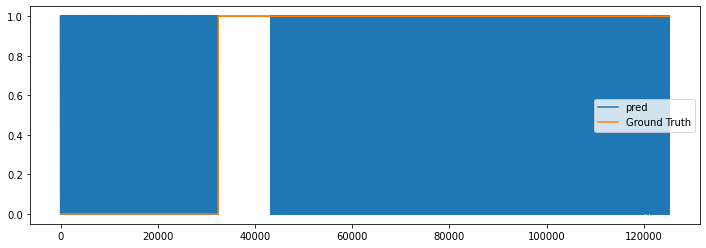

In [13]:
fig = plt.figure(figsize=(12, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

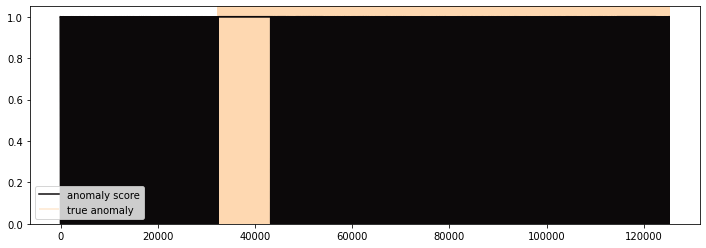

In [14]:
check_graph(IF_pred, np.array(Cathode_Test_y))
plt.show()

In [15]:
IF_anomaly_score = IF_clf.score_samples(Cathode_Test_X)

In [16]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-IF_anomaly_score, 
                                                                  np.array(Cathode_Test_y), 
                                                                  start=min(-IF_anomaly_score), 
                                                                  end=max(-IF_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.7267, F1: 0.8545, Precision: 0.7584, Recall: 0.9785


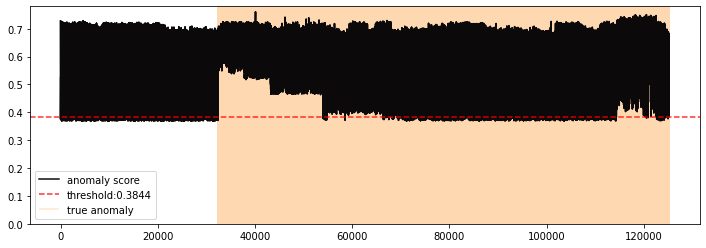

In [17]:
check_graph(-IF_anomaly_score, np.array(Cathode_Test_y), threshold=threshold)
plt.show()

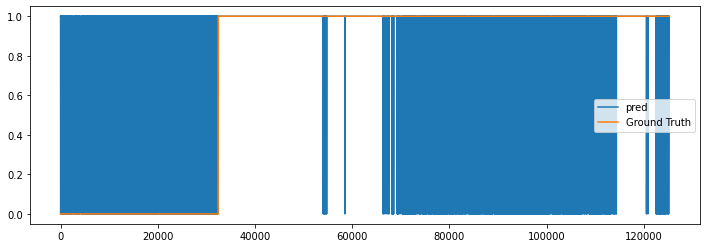

In [18]:
IF_pred = -IF_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [19]:
def anomaly_count_dict(testset, pred):
    anomaly_count_dict = {}
    testset['prediction'] = pred
    for bead in testset['identifier'].unique():
        anomaly_count_dict[bead] = dict(Counter(testset[testset['identifier'] == bead]['prediction']))
        
    
    return anomaly_count_dict

In [44]:
isf_anomaly_count_dict = anomaly_count_dict(Cathode_Test, IF_pred)
isf_anomaly_count_dict

{'Normal_75_0': {True: 94, False: 7},
 'Normal_75_1': {True: 92, False: 8},
 'Normal_75_2': {True: 89, False: 11},
 'Normal_75_3': {True: 90, False: 10},
 'Normal_75_4': {True: 93, False: 7},
 'Normal_75_5': {True: 95, False: 5},
 'Normal_75_6': {True: 95, False: 5},
 'Normal_75_7': {True: 87, False: 11},
 'Normal_75_8': {True: 91, False: 9},
 'Normal_75_9': {True: 87, False: 13},
 'Normal_75_10': {True: 89, False: 11},
 'Normal_75_11': {True: 94, False: 6},
 'Normal_75_12': {True: 98, False: 2},
 'Normal_75_13': {True: 88, False: 12},
 'Normal_75_14': {True: 96, False: 4},
 'Normal_75_15': {True: 86, False: 14},
 'Normal_75_16': {True: 88, False: 12},
 'Normal_75_17': {True: 85, False: 15},
 'Normal_75_18': {True: 88, False: 12},
 'Normal_75_19': {True: 83, False: 17},
 'Normal_75_20': {True: 88, False: 12},
 'Normal_75_21': {True: 95, False: 5},
 'Normal_75_22': {True: 94, False: 6},
 'Normal_75_23': {True: 95, False: 5},
 'Normal_75_24': {True: 97, False: 3},
 'Normal_75_25': {True:

In [21]:
def anomaly_counter_each_dataset(anomaly_count_dict, ratio):
    """
    dataset별로 anomaly인 bead의 갯수가 몇개인지 출력하는 함수
    bead의 timestamp 기준 True가 전체의 ratio 이상인 경우 정상 (True), 아닌 경우 (False)로 count
    """
    anomaly_counter_each_dataset_dict = {}
    true_count = 0
    false_count = 0
    for i, bead in enumerate(anomaly_count_dict.keys()):
        try:
            if anomaly_count_dict[bead][True] > anomaly_count_dict[bead][False] * ratio /(1-ratio):
                true_count = true_count + 1
            else:
                false_count = false_count + 1
        
        except:
            if 'True' in str(anomaly_count_dict[bead]):
                true_count = true_count + 1
            
            else:
                false_count = false_count + 1
        
        if i%54 == 53:
            name_list = bead.split('_') # ['Normal', dataset, bead_num]
            name = name_list[0] + name_list[1]
            anomaly_counter_each_dataset_dict[name] = {True: true_count, False: false_count}
            
            true_count = 0
            false_count = 0
    
    return anomaly_counter_each_dataset_dict

In [45]:
anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(isf_anomaly_count_dict , 0.9)
anomaly_counter_each_dataset_dict

{'Normal75': {True: 23, False: 31},
 'Normal76': {True: 17, False: 37},
 'Normal77': {True: 28, False: 26},
 'Normal78': {True: 22, False: 32},
 'Normal79': {True: 17, False: 37},
 'Normal80': {True: 30, False: 24},
 'Abnormal03': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 54, False: 0},
 'Abnormal07': {True: 54, False: 0},
 'Abnormal08': {True: 54, False: 0},
 'Abnormal09': {True: 54, False: 0},
 'Abnormal11': {True: 30, False: 24},
 'Abnormal12': {True: 47, False: 7},
 'Abnormal13': {True: 53, False: 1},
 'Abnormal14': {True: 52, False: 2},
 'Abnormal16': {True: 52, False: 2},
 'Abnormal17': {True: 51, False: 3},
 'Abnormal18': {True: 53, False: 1},
 'Abnormal19': {True: 54, False: 0},
 'Abnormal20': {True: 54, False: 0},
 'Abnormal21': {True: 54, False: 0}}

In [46]:
def metrics(anomaly_counter_each_dataset_dict):
    tn, fp, fn, tp = 0,0,0,0
    for name in anomaly_counter_each_dataset_dict.keys():
        if 'Ab' in name:
            tp = tp + anomaly_counter_each_dataset_dict[name][True]
            fn = fn + anomaly_counter_each_dataset_dict[name][False]
        
        else:
            fp = fp + anomaly_counter_each_dataset_dict[name][True]
            tn = tn + anomaly_counter_each_dataset_dict[name][False]

    recall = tp/(tp + fp)
    precision = tp/(tp + fn)
    f1 = 2*recall*precision/(recall + precision)
    
    return recall, precision, f1

In [47]:
recall, precision, f1 = metrics(anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.9084, precision: 0.9564, recall: 0.8650


### One-class SVM

In [23]:
OCS_clf = OneClassSVM().fit(Cathode_Train_X)
OCS_pred = OCS_clf.predict(Cathode_Test_X)
OCS_pred = np.where(OCS_pred==1, 0, 1)

In [24]:
tn, fp, fn, tp = confusion_matrix(Cathode_Test_y, OCS_pred).ravel()
(tn, fp, fn, tp)

(16237, 16191, 42109, 50702)

In [25]:
OCS_anomaly_score = OCS_clf.score_samples(Cathode_Test_X)

In [26]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-OCS_anomaly_score, 
                                                                  np.array(Cathode_Test_y), 
                                                                  start=min(-OCS_anomaly_score), 
                                                                  end=max(-OCS_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.5455, F1: 0.8446, Precision: 0.7425, Recall: 0.9792


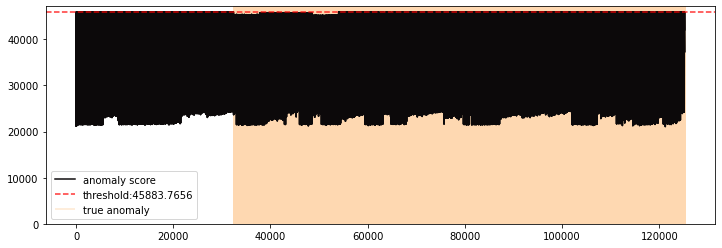

In [27]:
check_graph(OCS_anomaly_score, np.array(Cathode_Test_y), threshold=-threshold)
plt.show()

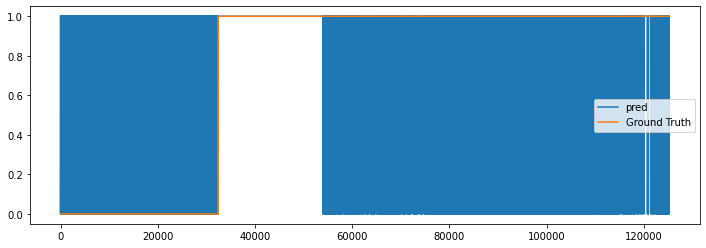

In [28]:
OCS_pred = OCS_anomaly_score <= -threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(OCS_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [48]:
OCM_anomaly_count_dict = anomaly_count_dict(Cathode_Test, OCS_pred)
OCM_anomaly_count_dict

{'Normal_75_0': {True: 98, False: 3},
 'Normal_75_1': {True: 97, False: 3},
 'Normal_75_2': {True: 97, False: 3},
 'Normal_75_3': {True: 97, False: 3},
 'Normal_75_4': {True: 96, False: 4},
 'Normal_75_5': {True: 97, False: 3},
 'Normal_75_6': {True: 96, False: 4},
 'Normal_75_7': {True: 96, False: 2},
 'Normal_75_8': {True: 96, False: 4},
 'Normal_75_9': {True: 97, False: 3},
 'Normal_75_10': {True: 97, False: 3},
 'Normal_75_11': {True: 96, False: 4},
 'Normal_75_12': {True: 97, False: 3},
 'Normal_75_13': {True: 96, False: 4},
 'Normal_75_14': {True: 97, False: 3},
 'Normal_75_15': {True: 97, False: 3},
 'Normal_75_16': {True: 97, False: 3},
 'Normal_75_17': {True: 96, False: 4},
 'Normal_75_18': {True: 98, False: 2},
 'Normal_75_19': {True: 98, False: 2},
 'Normal_75_20': {True: 97, False: 3},
 'Normal_75_21': {True: 98, False: 2},
 'Normal_75_22': {True: 97, False: 3},
 'Normal_75_23': {True: 98, False: 2},
 'Normal_75_24': {True: 97, False: 3},
 'Normal_75_25': {True: 99, False: 

In [49]:
OCM_anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(OCM_anomaly_count_dict, 0.9)
OCM_anomaly_counter_each_dataset_dict

{'Normal75': {True: 54, False: 0},
 'Normal76': {True: 54, False: 0},
 'Normal77': {True: 54, False: 0},
 'Normal78': {True: 54, False: 0},
 'Normal79': {True: 54, False: 0},
 'Normal80': {True: 54, False: 0},
 'Abnormal03': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 54, False: 0},
 'Abnormal07': {True: 50, False: 4},
 'Abnormal08': {True: 50, False: 4},
 'Abnormal09': {True: 54, False: 0},
 'Abnormal11': {True: 53, False: 1},
 'Abnormal12': {True: 54, False: 0},
 'Abnormal13': {True: 54, False: 0},
 'Abnormal14': {True: 54, False: 0},
 'Abnormal16': {True: 54, False: 0},
 'Abnormal17': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal19': {True: 54, False: 0},
 'Abnormal20': {True: 54, False: 0},
 'Abnormal21': {True: 54, False: 0}}

In [50]:
recall, precision, f1 = metrics(OCM_anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8452, precision: 0.9902, recall: 0.7372


### MoG

In [31]:
# Define the number of mixture components (Gaussian distributions)
n_components = 2

# Create a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components, random_state=72).fit(Cathode_Train_X)

In [32]:
# Predict cluster labels for each data point
cluster_labels = gmm.predict(Cathode_Test_X)

# Predict probabilities of each data point belonging to each cluster
cluster_probs = gmm.predict_proba(Cathode_Test_X)

AUROC: 0.7482, F1: 0.8574, Precision: 0.7846, Recall: 0.9452


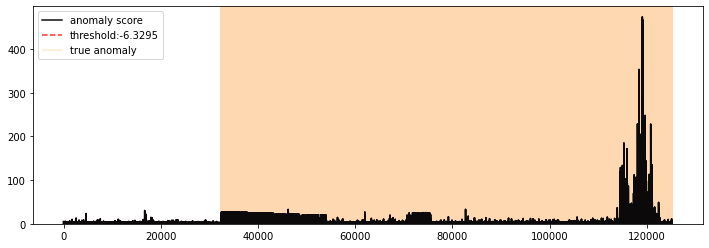

In [33]:
MoG_anomaly_score = gmm.score_samples(Cathode_Test_X)

(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-MoG_anomaly_score, 
                                                                  np.array(Cathode_Test_y), 
                                                                  start=min(-MoG_anomaly_score), 
                                                                  end=max(-MoG_anomaly_score), 
                                                                  step_num=10000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-MoG_anomaly_score, np.array(Cathode_Test_y), threshold=threshold)
plt.show()

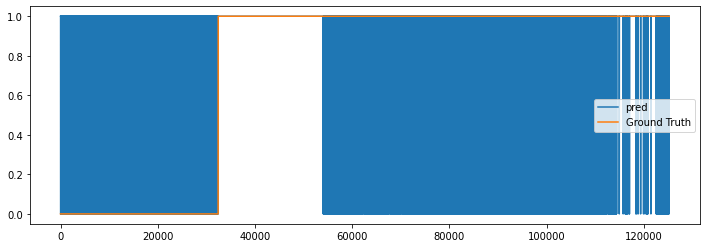

In [34]:
MoG_pred = -MoG_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(MoG_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [51]:
MOG_anomaly_count_dict = anomaly_count_dict(Cathode_Test, MoG_pred)
MOG_anomaly_count_dict

{'Normal_75_0': {True: 70, False: 31},
 'Normal_75_1': {True: 84, False: 16},
 'Normal_75_2': {True: 74, False: 26},
 'Normal_75_3': {True: 85, False: 15},
 'Normal_75_4': {True: 76, False: 24},
 'Normal_75_5': {True: 79, False: 21},
 'Normal_75_6': {True: 84, False: 16},
 'Normal_75_7': {True: 67, False: 31},
 'Normal_75_8': {True: 78, False: 22},
 'Normal_75_9': {True: 65, False: 35},
 'Normal_75_10': {True: 79, False: 21},
 'Normal_75_11': {True: 74, False: 26},
 'Normal_75_12': {True: 89, False: 11},
 'Normal_75_13': {True: 72, False: 28},
 'Normal_75_14': {True: 73, False: 27},
 'Normal_75_15': {True: 76, False: 24},
 'Normal_75_16': {True: 71, False: 29},
 'Normal_75_17': {True: 68, False: 32},
 'Normal_75_18': {True: 85, False: 15},
 'Normal_75_19': {True: 86, False: 14},
 'Normal_75_20': {True: 75, False: 25},
 'Normal_75_21': {True: 92, False: 8},
 'Normal_75_22': {True: 81, False: 19},
 'Normal_75_23': {True: 78, False: 22},
 'Normal_75_24': {True: 77, False: 23},
 'Normal_75

In [53]:
MoG_anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(MOG_anomaly_count_dict, 0.9)
MoG_anomaly_counter_each_dataset_dict

{'Normal75': {True: 3, False: 51},
 'Normal76': {True: 3, False: 51},
 'Normal77': {True: 2, False: 52},
 'Normal78': {True: 0, False: 54},
 'Normal79': {True: 0, False: 54},
 'Normal80': {True: 1, False: 53},
 'Abnormal03': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 54, False: 0},
 'Abnormal07': {True: 43, False: 11},
 'Abnormal08': {True: 48, False: 6},
 'Abnormal09': {True: 45, False: 9},
 'Abnormal11': {True: 10, False: 44},
 'Abnormal12': {True: 24, False: 30},
 'Abnormal13': {True: 30, False: 24},
 'Abnormal14': {True: 33, False: 21},
 'Abnormal16': {True: 31, False: 23},
 'Abnormal17': {True: 35, False: 19},
 'Abnormal18': {True: 46, False: 8},
 'Abnormal19': {True: 53, False: 1},
 'Abnormal20': {True: 54, False: 0},
 'Abnormal21': {True: 54, False: 0}}

In [54]:
recall, precision, f1 = metrics(MoG_anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8757, precision: 0.7865, recall: 0.9877


In [37]:
bead_counter = []
for i in range(len(MoG_pred)//54):
    bead_counter.append(dict(Counter(MoG_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 28, False: 26}, {False: 5, True: 49}, {True: 38, False: 16}, {True: 53, False: 1}, {True: 29, False: 25}, {True: 48, False: 6}, {True: 45, False: 9}, {True: 46, False: 8}, {True: 38, False: 16}, {True: 42, False: 12}, {False: 9, True: 45}, {True: 44, False: 10}, {True: 48, False: 6}, {True: 29, False: 25}, {True: 48, False: 6}, {True: 33, False: 21}, {False: 5, True: 49}, {True: 23, False: 31}, {True: 48, False: 6}, {True: 39, False: 15}, {True: 45, False: 9}, {False: 17, True: 37}, {True: 47, False: 7}, {False: 4, True: 50}, {True: 28, False: 26}, {True: 52, False: 2}, {True: 29, False: 25}, {True: 52, False: 2}, {True: 30, False: 24}, {True: 52, False: 2}, {False: 27, True: 27}, {True: 49, False: 5}, {False: 27, True: 27}, {True: 43, False: 11}, {True: 50, False: 4}, {True: 42, False: 12}, {True: 52, False: 2}, {True: 32, False: 22}, {True: 51, False: 3}, {True: 46, False: 8}, {True: 54}, {True: 35, False: 19}, {True: 50, False: 4}, {False: 16, True: 38}, {True: 44, False: 10

### Parzen windows

In [38]:
bandwidth = 1.0
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Cathode_Train_X)

AUROC: 0.5685, F1: 0.8487, Precision: 0.7424, Recall: 0.9905


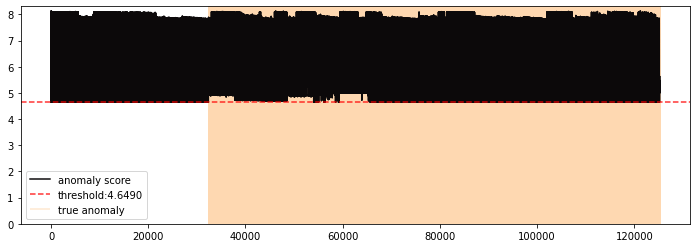

In [39]:
# Estimate the density at each value in the range
# density = np.exp(kde.score_samples(Anode_Test_X))
density = kde.score_samples(Cathode_Test_X)
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-density, 
                                                                  np.array(Cathode_Test_y), 
                                                                  start=min(-density), 
                                                                  end=max(-density), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-density, np.array(Cathode_Test_y), threshold=threshold)
plt.show()

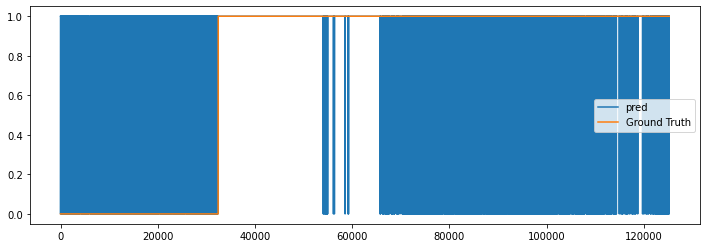

In [40]:
PW_pred = -density >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(PW_pred, label='pred')
plt.plot(np.array(Cathode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [56]:
PW_anomaly_count_dict = anomaly_count_dict(Cathode_Test, PW_pred)
PW_anomaly_count_dict

{'Normal_75_0': {True: 100, False: 1},
 'Normal_75_1': {True: 99, False: 1},
 'Normal_75_2': {True: 99, False: 1},
 'Normal_75_3': {True: 98, False: 2},
 'Normal_75_4': {True: 100},
 'Normal_75_5': {True: 97, False: 3},
 'Normal_75_6': {True: 99, False: 1},
 'Normal_75_7': {True: 97, False: 1},
 'Normal_75_8': {True: 98, False: 2},
 'Normal_75_9': {True: 99, False: 1},
 'Normal_75_10': {True: 98, False: 2},
 'Normal_75_11': {True: 98, False: 2},
 'Normal_75_12': {True: 99, False: 1},
 'Normal_75_13': {True: 98, False: 2},
 'Normal_75_14': {True: 98, False: 2},
 'Normal_75_15': {True: 98, False: 2},
 'Normal_75_16': {True: 98, False: 2},
 'Normal_75_17': {True: 99, False: 1},
 'Normal_75_18': {True: 99, False: 1},
 'Normal_75_19': {True: 98, False: 2},
 'Normal_75_20': {True: 98, False: 2},
 'Normal_75_21': {True: 98, False: 2},
 'Normal_75_22': {True: 98, False: 2},
 'Normal_75_23': {True: 99, False: 1},
 'Normal_75_24': {True: 98, False: 2},
 'Normal_75_25': {True: 98, False: 2},
 'No

In [57]:
PW_anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(PW_anomaly_count_dict, 0.9)
PW_anomaly_counter_each_dataset_dict

{'Normal75': {True: 54, False: 0},
 'Normal76': {True: 54, False: 0},
 'Normal77': {True: 54, False: 0},
 'Normal78': {True: 54, False: 0},
 'Normal79': {True: 54, False: 0},
 'Normal80': {True: 54, False: 0},
 'Abnormal03': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 54, False: 0},
 'Abnormal07': {True: 54, False: 0},
 'Abnormal08': {True: 54, False: 0},
 'Abnormal09': {True: 54, False: 0},
 'Abnormal11': {True: 54, False: 0},
 'Abnormal12': {True: 54, False: 0},
 'Abnormal13': {True: 54, False: 0},
 'Abnormal14': {True: 54, False: 0},
 'Abnormal16': {True: 54, False: 0},
 'Abnormal17': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal19': {True: 54, False: 0},
 'Abnormal20': {True: 54, False: 0},
 'Abnormal21': {True: 54, False: 0}}

In [58]:
recall, precision, f1 = metrics(PW_anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8500, precision: 1.0000, recall: 0.7391


In [43]:
bead_counter = []
for i in range(len(PW_pred)//54):
    bead_counter.append(dict(Counter(PW_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 51, False: 3}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 52, False: 2}, {True: 54}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 52, False: 2}, {True: 54}, {True: 52, False: 2}, {True: 54}, {True: 52, False: 2}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 52, False: 2}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 53, False: 1}, {True: 54}, {True: 53, False: 1}, {True: 54}, {True: 53, Fals

---